In [62]:
import pandas as pd
import geopandas as gpd
import os
from matplotlib import pyplot as plt
from unidecode import unidecode 
import re
from nltk.corpus import stopwords
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap
import branca.colormap as cm
import matplotlib.colors as colors
import folium
from matplotlib import pyplot as plt

In [2]:
#Directorio de adeudos
plt.rcParams['font.family'] = 'Poppins'
pd.set_option('display.float_format', '{:,.2f}'.format)
path="adeudos"

In [3]:
#Lista de archivos
files=os.listdir(path)
files

['adeudos_finales.csv',
 'adeudos_finales_finales.csv',
 'adeudo_0.csv',
 'adeudo_100000.csv',
 'adeudo_1000000.csv',
 'adeudo_1100000.csv',
 'adeudo_1200000.csv',
 'adeudo_1300000.csv',
 'adeudo_1400000.csv',
 'adeudo_1500000.csv',
 'adeudo_1600000.csv',
 'adeudo_1700000.csv',
 'adeudo_1900000.csv',
 'adeudo_200000.csv',
 'adeudo_2000000.csv',
 'adeudo_2100000.csv',
 'adeudo_2200000.csv',
 'adeudo_300000.csv',
 'adeudo_400000.csv',
 'adeudo_500000.csv',
 'adeudo_600000.csv',
 'adeudo_700000.csv',
 'adeudo_800000.csv',
 'adeudo_900000.csv',
 'adeudo_tot_partial_tmp.csv']

### Carga de padron predial

In [4]:
#Padrón de cuentas

padron_predial=pd.read_csv('padfiscal.txt', sep='|', encoding='latin1',on_bad_lines='skip', low_memory=False).rename(columns=str.lower)
#crea cuenta para adeudos
padron_predial["cuenta_adeudo"]=padron_predial['cuenta']+padron_predial['dv']
#Extrae los primeros 8 caracteres de la cuenta
padron_predial['cuenta_shp']=padron_predial['cuenta'].str[:8]
#Largo de cuenta_adeudo
padron_predial["largo"]=padron_predial['cuenta_adeudo'].str.len()
padron_predial = padron_predial.drop_duplicates(subset='cuenta_adeudo')
#Sustituir "PROPIETARIO O POSEEDRO" por "PROPIETARIO O POSEEDOR"
padron_predial["nomcon"] = padron_predial["nomcon"].str.replace("PROPIETARIO O POSEEDRO", "PROPIETARIO O POSEEDOR")
padron_predial["nomcon"]=padron_predial["nomcon"].str.replace("PROPIETARIO O POSSEDOR","PROPIETARIO O POSEEDOR")
padron_predial["nomcon"]=padron_predial["nomcon"].str.replace("POSEEDOR PROPIETARIO","PROPIETARIO O POSEEDOR")
#Sustituir por "Gobierno del Distrito Federal" si contiene "Departamento del Distrito Federal"
padron_predial["nomcon"] = padron_predial["nomcon"].str.replace("DEPARTAMENTO DEL DISTRITO FEDERAL", "GOBIERNO DEL DISTRITO FEDERAL")
print("Número de registros en padron_predial: ", len(padron_predial))
#Normalizar indcumpcol para que vaya de 0 a 1 utilizando máximos y mínimos
padron_predial["indcumpcol_norm"] = (padron_predial["indcumpcol"] - padron_predial["indcumpcol"].min()) / (padron_predial["indcumpcol"].max() - padron_predial["indcumpcol"].min())


padron_predial

Número de registros en padron_predial:  2291566


cuenta dv                                             nomcon  \
0        01101010000  3                               Maza Espinoza Orsue    
2        01101011000  2   BANCO INMOBILIARIO MEXICANO, SOCIEDAD ANÓNIMA...   
5        01101221000  8                  PRISCILA CYNTHIA CISNEROS BENÍTEZ   
9        01101321000  7                        Teja Maria Teresa Green de    
15       01101406000  5          FUNDACION MA ANA MIER DE ESCANDON I.A.P.    
...              ... ..                                                ...   
2441930  02601001689  2          BANAMEX FIBRA DANHOS FIDEICOMISO 17416-3    
2441945  02601001690  0          BANAMEX FIBRA DANHOS FIDEICOMISO 17416-3    
2441960  02601001691  8          BANAMEX FIBRA DANHOS FIDEICOMISO 17416-3    
2441975  02601001692  6          BANAMEX FIBRA DANHOS FIDEICOMISO 17416-3    
2441990  02601001693  4          BANAMEX FIBRA DANHOS FIDEICOMISO 17416-3    

                                   calle codpos          colonia  \
0               Cl. ALFONSO HERRERA, 49   06470       SAN RAFAEL   
2               Cl. ALFONSO HERRERA, 51   06470       SAN RAFAEL   
5                    Alfonso Herrera 70   06470       San Rafael   
9        Cl. MANUEL MARIA CONTRERAS, 40   06470       SAN RAFAEL   
15       Cl. MANUEL MARIA CONTRERAS, 45   06470       SAN RAFAEL   
...                                  ...    ...              ...   
2441930      AV CUAUHTEMOC 462 EST 4021   03000  PIEDAD NARVARTE   
2441945      AV CUAUHTEMOC 462 EST 4022   03000  PIEDAD NARVARTE   
2441960      AV CUAUHTEMOC 462 EST 4023   03000  PIEDAD NARVARTE   
2441975      AV CUAUHTEMOC 462 EST 4024   03000  PIEDAD NARVARTE   
2441990      AV CUAUHTEMOC 462 EST 4025   03000  PIEDAD NARVARTE   

                                domnotif        col_notif cp_notif  supter  \
0               Cl. ALFONSO HERRERA, 49        SAN RAFAEL    06470  560.85   
2               Cl. ALFONSO HERRERA, 51        SAN RAFAEL    06470  756.77   
5                ALFONSO HERRERA 70,           SAN RAFAEL    06470  241.00   
9        Cl. MANUEL MARIA CONTRERAS, 40        SAN RAFAEL    06470  989.82   
15         MANUEL MARA CONTRERAS 45,           SAN RAFAEL    06470  994.98   
...                                  ...              ...      ...     ...   
2441930      AV CUAUHTEMOC 462 EST 4021   PIEDAD NARVARTE    03000    3.80   
2441945      AV CUAUHTEMOC 462 EST 4022   PIEDAD NARVARTE    03000    3.80   
2441960      AV CUAUHTEMOC 462 EST 4023   PIEDAD NARVARTE    03000    3.80   
2441975      AV CUAUHTEMOC 462 EST 4024   PIEDAD NARVARTE    03000    3.80   
2441990      AV CUAUHTEMOC 462 EST 4025   PIEDAD NARVARTE    03000    3.80   

         ...  cve_vus          col_ind      deleg_ind     area  indcumpcol  \
0        ...  A060194       SAN RAFAEL     CUAUHTEMOC  A060194        0.75   
2        ...  A060194       SAN RAFAEL     CUAUHTEMOC  A060194        0.75   
5        ...  A060194       SAN RAFAEL     CUAUHTEMOC  A060194        0.75   
9        ...  A060194       SAN RAFAEL     CUAUHTEMOC  A060194        0.75   
15       ...  A060194       SAN RAFAEL     CUAUHTEMOC  A060194        0.75   
...      ...      ...              ...            ...      ...         ...   
2441930  ...   C-03-B  PIEDAD NARVARTE  BENITO JUAREZ      NaN        0.43   
2441945  ...   C-03-B  PIEDAD NARVARTE  BENITO JUAREZ      NaN        0.43   
2441960  ...   C-03-B  PIEDAD NARVARTE  BENITO JUAREZ      NaN        0.43   
2441975  ...   C-03-B  PIEDAD NARVARTE  BENITO JUAREZ      NaN        0.43   
2441990  ...   C-03-B  PIEDAD NARVARTE  BENITO JUAREZ      NaN        0.43   

         subsidio  cuenta_adeudo  cuenta_shp  largo indcumpcol_norm  
0            0.00   011010100003    01101010     12            0.00  
2            0.00   011010110002    01101011     12            0.00  
5            0.00   011012210008    01101221     12            0.00  
9            0.00   011013210007    01101321     12            0.00  
15           0.00   011014060005    

In [5]:
padron_predial[padron_predial["cuenta_shp"]=="00102113"]

cuenta dv                                    nomcon        calle  \
115718  00102113000  8   Suprema Corte de Justicia de la Nacion   Bolivar 30    

       codpos colonia     domnotif col_notif cp_notif   supter  ...  cve_vus  \
115718  06000  Centro  Bolivar 30     Centro    06000 2,435.00  ...  A060067   

       col_ind   deleg_ind     area  indcumpcol  subsidio  cuenta_adeudo  \
115718  CENTRO  CUAUHTEMOC  A060067        0.60      0.00   001021130008   

        cuenta_shp  largo indcumpcol_norm  
115718    00102113     12            0.00  

[1 rows x 33 columns]

Text(0.5, 1.0, 'Distribución de la variable indcumpcol normalizada')

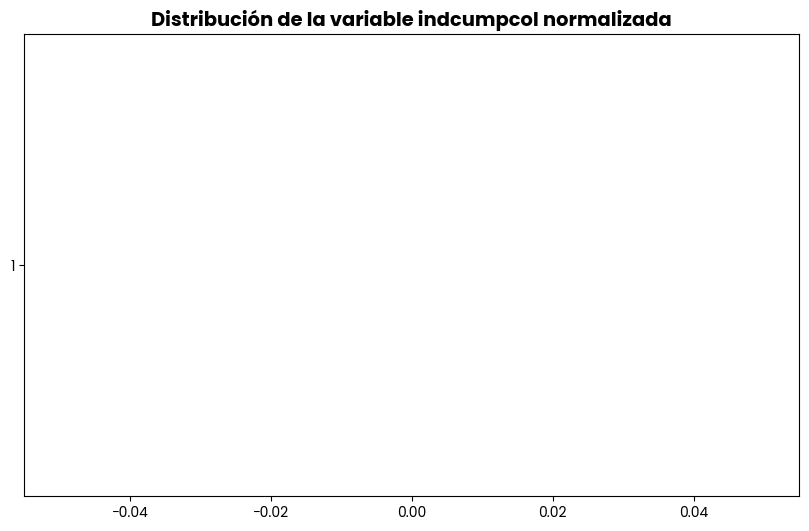

In [6]:
#Box plot de indcumpcol
plt.figure(figsize=(10, 6))
plt.boxplot(padron_predial["indcumpcol"], vert=False)
plt.title("Distribución de la variable indcumpcol normalizada", fontsize=14, fontweight="bold")

In [7]:
lista_stopwords = stopwords.words("spanish")

In [8]:
def limpia_nombre(text):
    if text is None:
        return ""
    # Elimina caracteres no alfanuméricos, caracteres, puntuación, espacios extras y signos de pesos
    cleaned_text = re.sub(r'[^\w\s.]', '', text).strip()
    #Eliminar espacios intermedios
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    #Eliminar puntos, comas y signos intermedios
    cleaned_text = re.sub(r'[.,]', '', cleaned_text)
    # Minúsculas
    cleaned_text = cleaned_text.lower()
    #Eliminar acentos
    cleaned_text = unidecode(cleaned_text)
    #Eliminar stopwords
    cleaned_text = " ".join([word for word in cleaned_text.split() if word not in lista_stopwords])
    return cleaned_text

In [9]:
#Limpiar nombres de contribuyentes
padron_predial["nomcon_clean"] = padron_predial["nomcon"].apply(limpia_nombre)
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("departamento distrito federal", "gobierno distrito federal")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("d d f", "gobierno distrito federal")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("df gobierno", "gobierno distrito federal")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("gobierno df", "gobierno distrito federal")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("gobierno d f", "gobierno distrito federal")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("departamento d f", "gobierno distrito federal")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("gobierno distrito federal s p v", "gobierno distrito federal")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("instituto mexicano seguro social","imss") 
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("servicios metropolitanos s c v", "servicios metropolitanos sa cv")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("instituto seguridad servicios sociales trabajadores","issste")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("propietario poseedor _","propietario poseedor")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("propieario poseedor","propietario poseedor")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("gobiero federal","gobierno federal")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("propietario poseedor _ _","propietario poseedor")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("depto d f","gobierno distrito federal")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("i n v i","invi")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("instituto vivienda df","invi")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("federal gobierno","gobierno federal")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("instituto pilotecnico nacional","instituto politecnico nacional")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("i n f n v i t","infonavit")
padron_predial["nomcon_clean"] = padron_predial["nomcon_clean"].str.replace("i m s s","imss")


In [10]:
padron_predial.columns

Index(['cuenta', 'dv', 'nomcon', 'calle', 'codpos', 'colonia', 'domnotif',
       'col_notif', 'cp_notif', 'supter', 'supcon', 'uso', 'tipo', 'clase',
       'ayocon', 'instal', 'vus', 'vsuelo', 'vuc', 'vconst', 'vcatas',
       'imp_total', 'imp_pagar', 'cve_vus', 'col_ind', 'deleg_ind', 'area',
       'indcumpcol', 'subsidio', 'cuenta_adeudo', 'cuenta_shp', 'largo',
       'indcumpcol_norm', 'nomcon_clean'],
      dtype='object')

In [11]:
padron_predial["tipo"]

0          02
2          05
5          05
9          05
15         10
           ..
2441930    10
2441945    10
2441960    10
2441975    10
2441990    10
Name: tipo, Length: 2291566, dtype: object

### Carga de adeudos

In [12]:
adeudos = pd.DataFrame()


for file in files:
    file_path = os.path.join(path, file)
    if os.path.getsize(file_path) > 0:  
        try:
            temp_df = pd.read_csv(file_path,low_memory=False)  
            if not temp_df.empty:  
                adeudos = pd.concat([adeudos, temp_df], ignore_index=True)
            else:
                print(f"Saltando archivo vacío: {file}")
        except pd.errors.EmptyDataError:
            print(f"Saltando archivo inválido: {file}")
    else:
        print(f"Saltando archivo vacío: {file}")
        
#Agregar bimestreconcat
adeudos["bimestreconcat"] = adeudos["anio"].astype(str) + adeudos["bimestre"].astype(str).str.zfill(2)
adeudos['bimester_date'] = pd.to_datetime(
    adeudos['anio'].astype(str) + '-' + ((adeudos['bimestre'].astype(int) * 2) - 1).astype(str).str.zfill(2) + '-01'
)
adeudos["cuenta_adeudo"] = adeudos["cuenta_adeudo"].astype(str)
adeudos["cuenta_shp"] = adeudos["cuenta_shp"].astype(str)
adeudos['cuenta_adeudo']=adeudos['cuenta_adeudo'].str.zfill(12)
adeudos['cuenta_shp']=adeudos['cuenta_shp'].str.zfill(8)
adeudos["largo"]=adeudos['cuenta_adeudo'].str.len()
adeudos["largo_shp"]=adeudos['cuenta_shp'].str.len()
#Clasificar si son de los últimos 5 años
adeudos["reciente"] = adeudos["anio"]>=2018

Saltando archivo inválido: adeudo_0.csv
Saltando archivo inválido: adeudo_900000.csv


In [13]:
len(adeudos)

30577898

In [14]:
#Pegar el uso a los adeudos
adeudos = adeudos.merge(padron_predial[["cuenta_adeudo", "uso", "tipo","vcatas", "deleg_ind"]], on="cuenta_adeudo", how="left")
len(adeudos)

30577898

In [15]:
#Total de monto adeudado
print("Total de adeudos: {:,.2f}".format(adeudos["monto"].sum()))
print("Total de cuentas con adeudos: {:,}".format(adeudos["cuenta_adeudo"].nunique()))
print("Porcentaje de cuentas con adeudos respecto del total: {:.2f}%".format(adeudos["cuenta_adeudo"].nunique()/padron_predial["cuenta"].nunique()*100))

Total de adeudos: 96,848,361,281.23
Total de cuentas con adeudos: 1,009,444
Porcentaje de cuentas con adeudos respecto del total: 44.05%


In [16]:
#Porcentaje de aduedos recientes
adeudos["reciente"].value_counts(normalize=True)*100

reciente
True    75.70
False   24.30
Name: proportion, dtype: float64

In [17]:
#Porcentaje de adeudos por uso con un decimal
adeudos["uso"].value_counts(normalize=True)*100

uso
H    69.26
K     7.56
W     7.23
C     5.33
O     3.39
PE    1.53
A     1.39
I     1.36
X     1.28
Q     0.81
S     0.21
PC    0.20
E     0.15
D     0.14
J     0.09
L     0.05
P     0.00
02    0.00
05    0.00
10    0.00
0     0.00
00    0.00
Name: proportion, dtype: float64

In [18]:
#Porcentaje de adeudos por tipo con un decimal
adeudos["tipo"].value_counts(normalize=True)*100

tipo
02        40.54
05        34.29
10         9.65
01         9.59
RU         1.97
15         1.49
99         1.46
20         1.00
3          0.00
4          0.00
5          0.00
2          0.00
1756.72    0.00
218.89     0.00
Name: proportion, dtype: float64

In [19]:
#Porcentaje de adeudos por delegación con un decimal
adeudos["deleg_ind"].value_counts(normalize=True)*100

deleg_ind
IZTAPALAPA              18.37
CUAUHTEMOC              11.10
GUSTAVO A. MADERO       10.02
TLALPAN                  7.84
ALVARO OBREGON           7.38
COYOACAN                 5.82
MIGUEL HIDALGO           5.45
BENITO JUAREZ            5.18
TLAHUAC                  4.82
VENUSTIANO CARRANZA      4.82
XOCHIMILCO               4.76
AZCAPOTZALCO             3.91
IZTACALCO                3.86
CUAJIMALPA DE MORELOS    2.86
MAGDALENA CONTRERAS      1.88
MILPA ALTA               1.73
Sin especificar          0.19
A040642                  0.00
A090592                  0.00
A060214                  0.00
A010635                  0.00
A060164                  0.00
A040194                  0.00
A090812                  0.00
A090141                  0.00
A060038                  0.00
A110374                  0.00
A110113                  0.00
A070262                  0.00
A090869                  0.00
A140880                  0.00
A010342                  0.00
A110453                  0.00


### Adeudos por bimestre

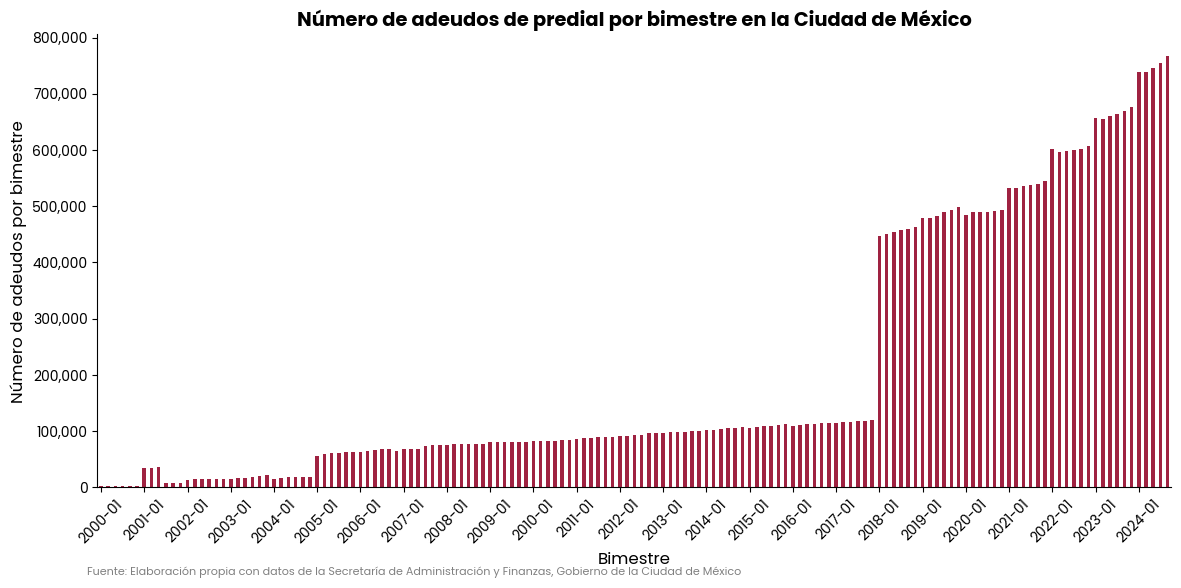

In [20]:

bimester_counts = adeudos['bimester_date'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(12, 6))
bimester_counts.plot(kind='bar', color='#9f2241')

# Title and labels
plt.title("Número de adeudos de predial por bimestre en la Ciudad de México", fontsize=14, fontweight="bold")
plt.xlabel("Bimestre", fontsize=12)
plt.ylabel("Número de adeudos por bimestre", fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
# Fix x-axis labels to show every 6th bimester (or yearly interval)
x_labels = bimester_counts.index
plt.xticks(
    ticks=range(0, len(x_labels), 6),  # Show every 6th label
    labels=[x.strftime('%Y-%m') for x in x_labels[::6]],  # Format date labels as 'YYYY-MM'
    rotation=45
)

#Fuente
plt.text(0.6, -0.2, 'Fuente: Elaboración propia con datos de la Secretaría de Administración y Finanzas, Gobierno de la Ciudad de México',
            verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes,
            color='gray', fontsize=8)

# Adjust layout to prevent overlap
plt.tight_layout()

#Eliminar bordes de arriba y derecha
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


#Salvar gráfica
plt.savefig('adeudos_predial_bimestre.png', dpi=300, bbox_inches='tight')

In [21]:
# Suma y porcentaje de adeudos por año y uso
adeudos_por_anio_uso = adeudos.groupby(["anio", "uso"]).agg(
    adeudos_total=("monto", "count")
).reset_index()

# Calculate the total 'monto' for each year to compute percentages within each 'anio'
total_monto_per_anio = adeudos.groupby("anio")["monto"].count()

# Merge total monto per year to calculate percentages
adeudos_por_anio_uso["adeudos_porcentaje"] = adeudos_por_anio_uso.apply(
    lambda row: (row["adeudos_total"] / total_monto_per_anio[row["anio"]]) * 100, axis=1
)

#Get the max uso by year
max_uso = adeudos_por_anio_uso.groupby("anio")["adeudos_total"].idxmax()
max_uso = adeudos_por_anio_uso.loc[max_uso]
max_uso


anio uso  adeudos_total  adeudos_porcentaje
4    2000  H            4107               33.99
32   2001  W           33753               26.38
38   2002  H           40481               45.62
55   2003  H           45546               42.34
72   2004  H           31784               29.35
89   2005  H           87692               24.09
107  2006  H           97520               24.69
124  2007  H          108753               25.32
141  2008  H          115279               24.85
158  2009  H          120228               24.75
175  2010  H          124157               24.92
192  2011  H          143974               27.09
209  2012  H          160215               28.42
226  2013  H          173175               29.22
243  2014  H          183891               29.31
263  2015  H          194277               29.56
283  2016  H          199852               29.60
304  2017  H          212643               30.30
325  2018  H         2231054               81.62
347  2019  H         2397867               82.05
368  2020  H         2375560               80.92
389  2021  H         2624286               81.41
410  2022  H         2990499               82.96
432  2023  H         3329254               83.60
454  2024  H         3154457               84.24

In [22]:
#Adeudos habitacionales

adeudos_habitacionales = adeudos[adeudos["uso"].str.contains("H", case=False)]
adeudos_habitacionales

cuenta_adeudo cuenta_shp  anio  bimestre    monto bimestreconcat  \
0         002080040005   00208004  2006         4 8,484.57         200604   
1         002080040005   00208004  2006         5 4,850.44         200605   
2         002080040005   00208004  2006         6 4,850.44         200606   
3         002080040005   00208004  2007         1 5,288.44         200701   
4         002080040005   00208004  2007         2 5,288.44         200702   
...                ...        ...   ...       ...      ...            ...   
30577829  019084020007   01908402  2024         1 6,056.50         202401   
30577830  019084020007   01908402  2024         2 6,056.50         202402   
30577831  019084020007   01908402  2024         3 6,056.50         202403   
30577832  019084020007   01908402  2024         4 6,056.50         202404   
30577833  019084020007   01908402  2024         5 6,056.50         202405   

         bimester_date  largo  largo_shp  reciente uso tipo          vcatas  \
0           2006-07-01     12          8     False  H    05  30115417.61216   
1           2006-09-01     12          8     False  H    05  30115417.61216   
2           2006-11-01     12          8     False  H    05  30115417.61216   
3           2007-01-01     12          8     False  H    05  30115417.61216   
4           2007-03-01     12          8     False  H    05  30115417.61216   
...                ...    ...        ...       ...  ..  ...             ...   
30577829    2024-01-01     12          8      True  H    05   3902089.20696   
30577830    2024-03-01     12          8      True  H    05   3902089.20696   
30577831    2024-05-01     12          8      True  H    05   3902089.20696   
30577832    2024-07-01     12          8      True  H    05   3902089.20696   
30577833    2024-09-01     12          8      True  H    05   3902089.20696   

                    deleg_ind  
0                  CUAUHTEMOC  
1                  CUAUHTEMOC  
2                  CUAUHTEMOC  
3                  CUAUHTEMOC  
4                  CUAUHTEMOC  
...                       ...  
30577829  VENUSTIANO CARRANZA  
30577830  VENUSTIANO CARRANZA  
30577831  VENUSTIANO CARRANZA  
30577832  VENUSTIANO CARRANZA  
30577833  VENUSTIANO CARRANZA  

[21177476 rows x 14 columns]

In [23]:
#vcatas a numérico
adeudos_habitacionales["vcatas"] = pd.to_numeric(adeudos_habitacionales["vcatas"], errors="coerce")

C:\Users\claud\AppData\Local\Temp\ipykernel_28180\2593053552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adeudos_habitacionales["vcatas"] = pd.to_numeric(adeudos_habitacionales["vcatas"], errors="coerce")


In [24]:
#Promedio de valor catastral, máximo y mínimo por año
adeudos_habitacionales.groupby("anio")["vcatas"].agg(
    vcatas_promedio=("mean"),
    vcatas_minimo=("min"),
    vcatas_maximo=("max")    
)

vcatas_promedio  vcatas_minimo    vcatas_maximo
anio                                                 
2000     5,336,309.23     712,772.43   115,859,941.72
2001     5,666,390.10     194,425.34   231,125,548.08
2002     5,471,620.30     387,389.26   231,125,548.08
2003     5,604,002.21     235,436.94   350,329,196.45
2004     6,983,122.59      68,370.87   350,329,196.45
2005     5,256,211.83      26,535.63   350,329,196.45
2006     5,238,253.19      26,535.63   817,121,438.70
2007     5,183,413.11      26,535.63   533,182,491.83
2008     5,212,203.86      26,535.63   533,182,491.83
2009     5,233,105.72      24,073.56 1,647,536,893.10
2010     5,184,353.16      24,073.56 1,647,536,893.10
2011     5,121,373.65      24,073.56 1,647,536,893.10
2012     4,972,792.93      24,073.56 1,647,536,893.10
2013     4,917,203.42      24,073.56 1,647,536,893.10
2014     4,918,484.03      21,179.76 1,647,536,893.10
2015     4,835,935.59      21,179.76 1,647,536,893.10
2016     4,803,193.25      21,179.76 1,647,536,893.10
2017     4,728,721.75      21,179.76 1,647,536,893.10
2018     1,166,800.82       1,422.62 1,647,536,893.10
2019     1,149,466.92       1,422.62 1,647,536,893.10
2020     1,160,950.38       1,422.62 1,647,536,893.10
2021     1,160,332.24       1,422.62 1,647,536,893.10
2022     1,120,273.11       1,422.62 1,647,536,893.10
2023     1,111,729.03           0.00 1,647,536,893.10
2024     1,100,597.19           0.00 1,647,536,893.10

In [25]:
cuentas_max_vcatas = adeudos_habitacionales[
    adeudos_habitacionales["vcatas"] == adeudos_habitacionales["vcatas"].max()
][["cuenta_adeudo"]].drop_duplicates()


#Pegar el nomcon y el valor catastral
cuentas_max_vcatas = cuentas_max_vcatas.merge(padron_predial[["cuenta_adeudo", "nomcon","nomcon_clean","domnotif", "col_notif","vcatas"]], on="cuenta_adeudo", how="left")
cuentas_max_vcatas


cuenta_adeudo                               nomcon  \
0  167412050004   SECRETARIA DE LA DEFENSA NACIONAL    

                  nomcon_clean                             domnotif  \
0  secretaria defensa nacional  Cda. HECTOR ORTIZ, MZ-3 LT-2 4 y 6    

   col_notif              vcatas  
0  EL VERGEL  1647536893.1003616

In [26]:
print("Largo de cuenta de adeudos: ", adeudos["largo"].unique())
print("Largo de cuenta shape: ", adeudos["largo_shp"].unique())

Largo de cuenta de adeudos:  [12]
Largo de cuenta shape:  [8]


In [27]:
print("Cuentas con adeudos vencidos de predial: {:,}".format(adeudos["cuenta_adeudo"].nunique()))
print("Monto adeudado: {:,.2f}".format(adeudos["monto"].sum()))

Cuentas con adeudos vencidos de predial: 1,009,444
Monto adeudado: 96,848,361,281.23


In [28]:
adeudos.head()

cuenta_adeudo cuenta_shp  anio  bimestre    monto bimestreconcat  \
0  002080040005   00208004  2006         4 8,484.57         200604   
1  002080040005   00208004  2006         5 4,850.44         200605   
2  002080040005   00208004  2006         6 4,850.44         200606   
3  002080040005   00208004  2007         1 5,288.44         200701   
4  002080040005   00208004  2007         2 5,288.44         200702   

  bimester_date  largo  largo_shp  reciente uso tipo          vcatas  \
0    2006-07-01     12          8     False  H    05  30115417.61216   
1    2006-09-01     12          8     False  H    05  30115417.61216   
2    2006-11-01     12          8     False  H    05  30115417.61216   
3    2007-01-01     12          8     False  H    05  30115417.61216   
4    2007-03-01     12          8     False  H    05  30115417.61216   

    deleg_ind  
0  CUAUHTEMOC  
1  CUAUHTEMOC  
2  CUAUHTEMOC  
3  CUAUHTEMOC  
4  CUAUHTEMOC

In [29]:
#Agrupar por cuenta y obtener número de bimestres adeudados y monto total adeudado y bimestre más antiguo
adeudos_agrupados = adeudos.groupby("cuenta_adeudo").agg(
    bimestres_adeudados=("bimester_date", "count"),
    monto_adeudado=("monto", "sum"),
    bimestre_mas_antiguo=("bimester_date", "min")
).reset_index()
#adeudos_agrupados["monto_adeudo_prom"]=adeudos_agrupados["monto_adeudado"]/adeudos_agrupados["bimestres_adeudados"]
#Ordenar por monto adeudado y bimestres adeudados
adeudos_agrupados = adeudos_agrupados.sort_values(["monto_adeudado"], ascending=False)
#Calcular porcentaje de adeudo total
adeudos_agrupados["porcentaje_adeudo"] = adeudos_agrupados["monto_adeudado"] / adeudos["monto"].sum()*100
adeudos_agrupados

cuenta_adeudo  bimestres_adeudados   monto_adeudado  \
129957  021019010004                   61 4,491,306,932.33   
892465  377640040004                  129 1,119,059,417.79   
54916   009085010008                  132   838,405,234.23   
505240  061798010007                   71   586,036,267.90   
80657   012033010005                  116   531,855,475.22   
...              ...                  ...              ...   
445422  057179040001                    1          -575.13   
356241  049282013744                    1          -580.14   
762295  167104110009                    1          -735.97   
624798  073936090007                    1        -1,716.28   
127707  020244130009                    1        -3,345.00   

       bimestre_mas_antiguo  porcentaje_adeudo  
129957           2011-01-01               4.64  
892465           2001-01-01               1.16  
54916            2001-05-01               0.87  
505240           2013-01-01               0.61  
80657            2005-05-01               0.55  
...                     ...                ...  
445422           2019-11-01              -0.00  
356241           2019-11-01              -0.00  
762295           2019-01-01              -0.00  
624798           2019-11-01              -0.00  
127707           2022-01-01              -0.00  

[1009444 rows x 5 columns]

In [30]:
# Cruzar con padrón para obtener datos de propietario
adeudos_propietario = adeudos_agrupados.merge(padron_predial, on="cuenta_adeudo", how="left")
#Reordenar para que después de cuenta_adeudo venga el nombre del propietario
adeudos_propietario = adeudos_propietario[["cuenta_adeudo", "nomcon","nomcon_clean","calle","colonia", "deleg_ind","bimestres_adeudados", "monto_adeudado", "bimestre_mas_antiguo","porcentaje_adeudo","vcatas", "uso"]]
#Dejar primeros 10
adeudos_propietario.head(10)

cuenta_adeudo                                      nomcon  \
0  021019010004   PROPIETARIO O POSEEDOR                      
1  377640040004              GASTRONOMIA SANTA FE SA DE CV    
2  009085010008                     PROPIETARIO O POSEEDOR    
3  061798010007   INSTITUTO POLITECNICO NACIONAL              
4  012033010005         Ferrocarriles Nacionales De Mexico    
5  377351050002   PRESIDENCIA DE LA REPUBLICA                 
6  058729270007         Inmobiliaria Rinconada Coapa, S.A.    
7  060353010006   SECRETARIA DE MARINA ARMADA DE MEXICO       
8  161071010003   INSTITUTO POLITECNICO NACIONAL              
9  044754020004                     PROPIETARIO O POSEEDOR    

                      nomcon_clean  \
0             propietario poseedor   
1       gastronomia santa fe sa cv   
2             propietario poseedor   
3   instituto politecnico nacional   
4  ferrocarriles nacionales mexico   
5            presidencia republica   
6  inmobiliaria rinconada coapa sa   
7  secretaria marina armada mexico   
8   instituto politecnico nacional   
9             propietario poseedor   

                                               calle  \
0                             AV 602 VIA TAPO   161    
1  JAVIER BARROSO SIERRA S N ESQ FERNANDO ESPINOZ...   
2                                    Dr Marquez 162    
3               PONIENTE 152 (WILFRIDO MASSIEU) S/N    
4                          EJE 1 NORTE MOSQUETA 259    
5                                CONSTITUYENTES 851    
6                      Anillo Periferico Lt 3 Mz 23    
7             EJE 10 SUR CALZADA DE LA VIRGEN, 1800    
8                       Avd. LUIS ENRIQUE ERRO, S/N    
9                                        Rabaul 500    

                                    colonia            deleg_ind  \
0     ARPTO INT DE LA CD DE MEX-EQUIPAMIENT  VENUSTIANO CARRANZA   
1                                  SANTA FE       ALVARO OBREGON   
2                                  Doctores           CUAUHTEMOC   
3  U P ADOLFO LOPEZ MATEOS                     GUSTAVO A. MADERO   
4                                BUENAVISTA           CUAUHTEMOC   
5                       BELEN DE LAS FLORES       ALVARO OBREGON   
6                           Rinconada Coapa           XOCHIMILCO   
7              EX EJIDO SAN PABLO TEPETLAPA             COYOACAN   
8                  NUEVA INDUSTRIAL VALLEJO    GUSTAVO A. MADERO   
9                           Jardin Aspeitia         AZCAPOTZALCO   

   bimestres_adeudados   monto_adeudado bimestre_mas_antiguo  \
0                   61 4,491,306,932.33           2011-01-01   
1                  129 1,119,059,417.79           2001-01-01   
2                  132   838,405,234.23           2001-05-01   
3                   71   586,036,267.90           2013-01-01   
4                  116   531,855,475.22           2005-05-01   
5                   86   349,928,764.55           2010-07-01   
6                  122   336,868,509.48           2001-01-01   
7                  130   306,376,634.41           2003-01-01   
8                   71   297,702,305.15           2013-01-01   
9                   69   286,045,686.91           2001-05-01   

   porcentaje_adeudo                vcatas uso  
0               4.64  35692990575.51852176  K   
1               1.16         6375165269.85  W   
2               0.87       4249391932.1368  S   
3               0.61     4189148310.705408  PE  
4               0.55  2942309605.147055808  K   
5               0.36   2208934897.92729936  D   
6               0.35          1678831737.6  W   
7               0.32  1583265270.718028544  O   
8               0.31  2153110222.915148928  E   
9               0.30      2081853712.29096  K

In [31]:
#Dejar solo los usos "H" de adeudos_propietario
adeudos_propietario_h = adeudos_propietario[adeudos_propietario["uso"].str.contains("H", case=False)]
adeudos_propietario_h

cuenta_adeudo                                      nomcon  \
40       167412050004          SECRETARIA DE LA DEFENSA NACIONAL    
65       073702010007   Instituto de Seguridad Social Para las F    
70       056960010009        Grand Santa Fe Oriente S.A. De C.V.    
101      056857300000   PROPIETARIO O POSEEDOR                      
125      061735020002       INSTITUTO MEXICANO DEL SEGURO SOCIAL    
...               ...                                         ...   
1009439  057179040001                  RAMON AVILEZ ROJAS Y COPR.   
1009440  049282013744                  PROPIETARIO O POSEEDOR - -   
1009441  167104110009                     RUIZ BARRITA RAMONA R.    
1009442  073936090007                     Ugalde Gutierrez Laura    
1009443  020244130009                         LOPEZ MAVIL FELIPE    

                         nomcon_clean  \
40        secretaria defensa nacional   
65       instituto seguridad social f   
70       grand santa fe oriente sa cv   
101              propietario poseedor   
125                              imss   
...                               ...   
1009439       ramon avilez rojas copr   
1009440          propietario poseedor   
1009441         ruiz barrita ramona r   
1009442        ugalde gutierrez laura   
1009443            lopez mavil felipe   

                                                     calle  \
40                     Cda. HECTOR ORTIZ, MZ-3 LT-2 4 y 6    
65                                  Calz. DEL HUESO, 7700    
70                                  Av Santa Fe Mz D Lt 1    
101                              PASEO DEL PARQUE     314    
125             Avd. INSTITUTO POLITECNICO NACIONAL, 1600    
...                                                    ...   
1009439                      Cl. LAS BODAS DE FIGARO, 352    
1009440  Cl. SAN FRANCISCO XOCOTITLA, 119 Edif. C2, Dpt...   
1009441                                  Calle Uno Num.21    
1009442  Hacienda de Mimiahuapan Poniente 25 Floresta C...   
1009443                                   Oriente 180 278    

                     colonia              deleg_ind  bimestres_adeudados  \
40                 EL VERGEL             IZTAPALAPA                   94   
65             GRANJAS COAPA                TLALPAN                   67   
70                   Tlaxala  CUAJIMALPA DE MORELOS                  107   
101      SANTA FE CUAJIMALPA  CUAJIMALPA DE MORELOS                   83   
125           LINDAVISTA SUR      GUSTAVO A. MADERO                  122   
...                      ...                    ...                  ...   
1009439       MIGUEL HIDALGO                TLAHUAC                    1   
1009440              DEL GAS           AZCAPOTZALCO                    1   
1009441       San Juan Xalpa             IZTAPALAPA                    1   
1009442                                     TLALPAN                    1   
1009443           Mooctezuma    VENUSTIANO CARRANZA                    1   

         monto_adeudado bimestre_mas_antiguo  porcentaje_adeudo  \
40       145,549,741.02           2009-03-01               0.15   
65       106,034,556.90           2006-09-01               0.11   
70        99,957,450.91           2007-01-01               0.10   
101       79,551,068.19           2011-01-01               0.08   
125       66,590,282.13           2003-09-01               0.07   
...                 ...                  ...                ...   
1009439         -575.13           2019-11-01              -0.00   
1009440         -580.14           2019-11-01              -0.00   
1009441         -735.97           2019-01-01              -0.00   
1009442       -1,716.28           2019-11-01              -0.00   
1009443       -3,345.00           2022-01-01              -0.00   

                      vcatas uso  
40        1647536893.1003616  H   
65       817121438.701902112  H   
70             533182491.832  H   
101           514757761.7028  H   
125      350329196.446393536  H   
...          

In [32]:
#Filtrar adeudos de "GOBIERNO DEL DISTRITO FEDERAL"
adeudos_gdf = adeudos_propietario[adeudos_propietario["nomcon_clean"].str.contains("gobierno distrito federal", case=False)]
print("Total de monto adeudado por GobCDMX: {:,.2f}".format(adeudos_gdf["monto_adeudado"].sum()))
print("Monto de adeudo GOBCDMX respecto del total: {:.2f}%".format(adeudos_gdf["monto_adeudado"].sum()/adeudos["monto"].sum()*100))
adeudos_gdf

Total de monto adeudado por GobCDMX: 3,030,281,366.34
Monto de adeudo GOBCDMX respecto del total: 3.13%


cuenta_adeudo                                      nomcon  \
27      167309010004              GOBIERNO DEL DISTRITO FEDERAL    
39      068627010009                            D,F GOBIERNO DEL   
42      072900010009                            D,F GOBIERNO DEL   
59      002113180000             GOBIERNO DEL  DISTRITO FEDERAL    
66      002095010001   GOBIERNO DEL DISTRITO FEDERAL               
...              ...                                         ...   
903811  020156200105         INSTITUTO DE VIVIEND DEL D F (INVI)   
928128  038229160007                                      D D F    
940138  023405080005                               GOBIERNO D F    
974301  073567940009       El Departamento del Distrito Federal    
987701  020156200113         INSTITUTO DE VIVIEND DEL D F (INVI)   

                                          nomcon_clean  \
27                           gobierno distrito federal   
39                           gobierno distrito federal   
42                           gobierno distrito federal   
59                           gobierno distrito federal   
66                           gobierno distrito federal   
...                                                ...   
903811  instituto viviengobierno distrito federal invi   
928128                       gobierno distrito federal   
940138                       gobierno distrito federal   
974301                       gobierno distrito federal   
987701  instituto viviengobierno distrito federal invi   

                                                  calle  \
27                                   Cl. RIO NILO, 100    
39                                    Cl. MORELOS, S/N    
42                     Cl. LIC MARTINEZ DE CASTRO, S/N    
59                                       Dr Jimenez 56    
66                                      DR LAVISTA 144    
...                                                 ...   
903811                              Cl. 16, 5 Dpto. 302   
928128  BOULEVARD ADOLFO LOPEZ MATEOS S N ESQ CALLE 12    
940138                                   Cl. 1325, S/N    
974301                                    Cafetales 50    
987701                              Cl. 16, 5 Dpto. 303   

                       colonia            deleg_ind  bimestres_adeudados  \
27        LOMAS DE SAN LORENZO           IZTAPALAPA                  118   
39         CHALMA DE GUADALUPE    GUSTAVO A. MADERO                   68   
42      PUEBLO SAN MATEO XALPA           XOCHIMILCO                   68   
59                    Doctores           CUAUHTEMOC                  130   
66                    Doctores           CUAUHTEMOC                  118   
...                        ...                  ...                  ...   
903811    MOCTEZUMA 1A SECCION  VENUSTIANO CARRANZA                    5   
928128  SAN PEDRO DE LOS PINOS        BENITO JUAREZ                    6   
940138              DEL PARQUE  VENUSTIANO CARRANZA                    4   
974301       Ex-hacienda Coapa              TLALPAN                    1   
987701    MOCTEZUMA 1A SECCION  VENUSTIANO CARRANZA                    1   

        monto_adeudado bimestre_mas_antiguo  porcentaje_adeudo  \
27      180,280,154.91           2005-01-01               0.19   
39      146,157,680.91           2013-07-01               0.15   
42      144,026,804.11           2013-07-01               0.15   
59      113,141,733.29           2002-11-01               0.12   
66      102,327,331.20           2005-01-01               0.11   
...                ...                  ...                ...   
903811          355.00           2024-01-01               0.00   
928128          312.00           2021-01-01               0.00   
940138          248.00           2024-03-01               0.00   
974301           86.00           2024-01-01               0.00   
987701           71.00           2024-09-01               0.00   

                      vcatas uso  
27         906700727.4932672  O   
39      

In [33]:
#Número de contribuyentes con adeudos
print("Número de contribuyentes con adeudos: {:,}".format(adeudos_propietario["nomcon_clean"].nunique()))

Número de contribuyentes con adeudos: 611,296


In [34]:
#Tabla de contribuyentes con adeudos por monto
tabla_adeudos=adeudos_propietario.groupby(["nomcon_clean"]).agg(
    adeudos_total=("monto_adeudado", "sum"),
    adeudos_cuentas=("cuenta_adeudo", "count")
).sort_values("adeudos_total", ascending=False)
#Agregar porcentaje
tabla_adeudos["porcentaje_adeudos"] = tabla_adeudos["adeudos_total"]/adeudos["monto"].sum()*100
#Dejar solo los primeros 10
tabla_adeudos=tabla_adeudos.head(10)
#Reseteo de índice
tabla_adeudos = tabla_adeudos.reset_index()
tabla_adeudos.columns=['Nombre del contribuyente','Adeudo total (pesos)','Número de cuentas con adeudo','Porcentaje']
tabla_adeudos["Adeudo total (pesos)"] = tabla_adeudos["Adeudo total (pesos)"].map("{:,.2f}".format)
tabla_adeudos["Porcentaje"] = tabla_adeudos["Porcentaje"].map("{:.2f}%".format)
tabla_adeudos["Número de cuentas con adeudo"] = tabla_adeudos["Número de cuentas con adeudo"].map("{:,.0f}".format)
tabla_adeudos

Nombre del contribuyente Adeudo total (pesos)  \
0             propietario poseedor    27,419,923,782.95   
1        gobierno distrito federal     2,839,979,590.10   
2   instituto politecnico nacional     2,003,173,002.90   
3                 gobierno federal     1,362,130,428.05   
4       gastronomia santa fe sa cv     1,119,059,417.79   
5                             imss     1,110,824,619.94   
6   servicios metropolitanos sa cv       916,419,315.97   
7  ferrocarriles nacionales mexico       532,424,002.31   
8          club golf reforma sa cv       513,136,579.74   
9  secretaria marina armada mexico       432,049,115.95   

  Número de cuentas con adeudo Porcentaje  
0                      196,121     28.31%  
1                          782      2.93%  
2                           45      2.07%  
3                          550      1.41%  
4                            1      1.16%  
5                           87      1.15%  
6                           59      0.95%  
7                            5      0.55%  
8                            6      0.53%  
9                            4      0.45%

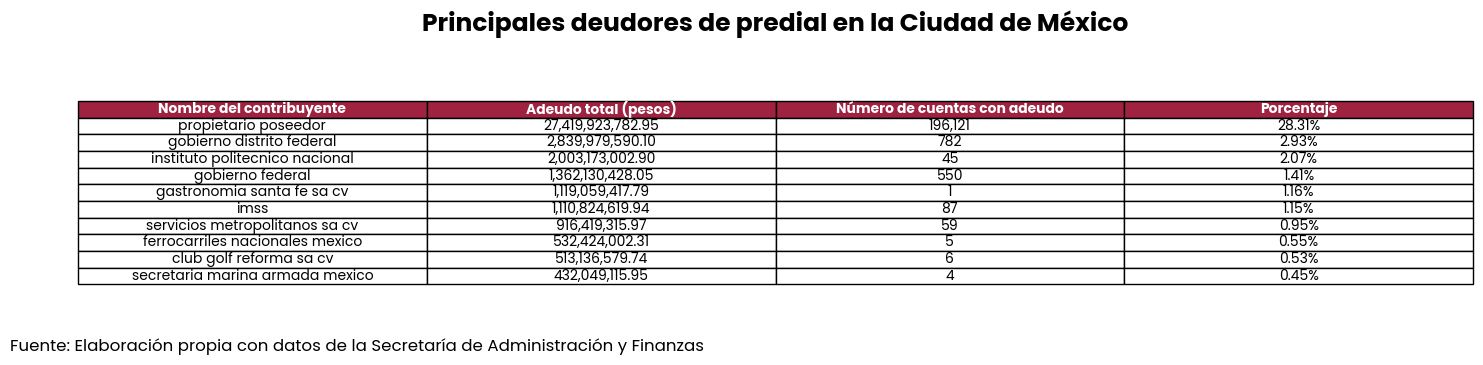

In [35]:
# Definir color de la tabla
colors = ["#9f2241","#9f2241"] 
cm = LinearSegmentedColormap.from_list('custom', colors, N=10)

fig, ax = plt.subplots(figsize=(18, 4))
num_columns = len(tabla_adeudos.columns)

# Aplicar el color a las columnas
col_colours = [cm(0.3 + i * (0.7 - 0.3) / (num_columns - 1)) for i in range(num_columns)]
#Agregar titulo
plt.title('Principales deudores de predial en la Ciudad de México',  fontsize=18, fontweight='bold', color='black')
#Eliminar ejes
plt.axis('off')
#Añadir fuente
plt.text(0.2, 0, "Fuente: Elaboración propia con datos de la Secretaría de Administración y Finanzas"
                , ha='center', va='center', fontsize=12, color='black')

# Crear tabla
table = ax.table(cellText=tabla_adeudos.values, colLabels=tabla_adeudos.columns, loc='center', colColours=col_colours)

# Ajustar tamaño de fuente
table.auto_set_font_size(False)
table.set_fontsize(10)


    
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header row
        cell.set_text_props(ha='center', color='white', fontweight='bold')
    else:
        cell.set_text_props(ha='center')
    
plt.savefig('tabla_deudores_predial.png', dpi=300, bbox_inches='tight')


In [36]:
#Filtrar adeudos de Suprema Corte de Justicia de la Nación
adeudos_scjn = adeudos_propietario[adeudos_propietario["nomcon"].str.contains("SUPREMA CORTE DE JUSTICIA DE LA NACION", case=False)]
print("Total de monto adeudado por SCJN: {:,.2f}".format(adeudos_scjn["monto_adeudado"].sum()))
print("Monto de adeudo SCJN respecto del total: {:.2f}%".format(adeudos_scjn["monto_adeudado"].sum()/adeudos["monto"].sum()*100))
adeudos_scjn

Total de monto adeudado por SCJN: 124,571,050.68
Monto de adeudo SCJN respecto del total: 0.13%


cuenta_adeudo                                       nomcon  \
80     054585050005      Suprema Corte De Justicia De La Nacion    
781    006041010007      Suprema Corte de Justicia de la Nacion    
1427   001091040004   LA SUPREMA CORTE DE JUSTICIA DE LA NACION    
1857   001021120009      Suprema Corte de Justicia de la Nacion    
2628   369569010001      Suprema Corte De Justicia De La Nacion    
3811   054585440008      Suprema Corte De Justicia De La Nacion    
6368   001042090009      Suprema Corte de Justicia de la Nacion    
13649  001021130008      Suprema Corte de Justicia de la Nacion    
42330  001021110000      Suprema Corte de Justicia de la Nacion    

                        nomcon_clean  \
80     suprema corte justicia nacion   
781    suprema corte justicia nacion   
1427   suprema corte justicia nacion   
1857   suprema corte justicia nacion   
2628   suprema corte justicia nacion   
3811   suprema corte justicia nacion   
6368   suprema corte justicia nacion   
13649  suprema corte justicia nacion   
42330  suprema corte justicia nacion   

                                                   calle       colonia  \
80              Boulevard Adolfo Lopez Mateos 2321 Lt-A       Atlamaya   
781                       Cl. JOSE MARIA PINO SUAREZ, 2         CENTRO   
1427                                   Chimalpopoca 112         CENTRO   
1857                                16 de Septiembre 38         Centro   
2628   Calz. Ignacio Zaragoza # 1340 Esq. Eulogio Parra   Juan Escutia   
3811           Boulevard Adolfo Lopez Mateos 2323 Lt.-B       Atlamaya   
6368                                Rep del Salvador 56         Centro   
13649                                        Bolivar 30         Centro   
42330                               16 de Septiembre 40         Centro   

            deleg_ind  bimestres_adeudados  monto_adeudado  \
80     ALVARO OBREGON                  106   92,495,258.04   
781        CUAUHTEMOC                   17   12,288,039.82   
1427       CUAUHTEMOC                   29    6,358,338.44   
1857       CUAUHTEMOC                   29    4,894,927.51   
2628       IZTAPALAPA                   47    3,542,399.28   
3811   ALVARO OBREGON                  106    2,464,129.66   
6368       CUAUHTEMOC                   29    1,527,544.52   
13649      CUAUHTEMOC                   17      744,670.85   
42330      CUAUHTEMOC                   29      255,742.56   

      bimestre_mas_antiguo  porcentaje_adeudo              vcatas uso  
80              2007-01-01               0.10      503848854.8476  O   
781             2020-01-01               0.01  310028291.05903488  O   
1427            2020-01-01               0.01   94193603.94075808  PE  
1857            2020-01-01               0.01     74014848.582884  O   
2628            2017-01-01               0.00     38053922.876352  A   
3811            2007-01-01               0.00          16402395.1  W   
6368            2020-01-01               0.00      24952822.44736  C   
13649           2020-01-01               0.00          21389819.2  W   
42330           2020-01-01               0.00        5473786.8276  O

### Adeudos por cuenta catastral

In [37]:
adeudos_predios=adeudos_agrupados = adeudos.groupby("cuenta_shp").agg(
    bimestres_adeudados=("bimester_date", "count"),
    monto_adeudado=("monto", "sum"),
    bimestre_mas_antiguo=("bimester_date", "min")
).reset_index()
adeudos_predios

cuenta_shp  bimestres_adeudados  monto_adeudado bimestre_mas_antiguo
0        00100101                   15    2,245,772.87           2019-01-01
1        00100102                    1        1,542.07           2024-09-01
2        00100201                   28   11,272,376.35           2011-01-01
3        00100308                  138    1,052,452.18           2001-01-01
4        00100311                   13      266,870.73           2022-07-01
...           ...                  ...             ...                  ...
536688   79050250                   41       49,424.31           2018-01-01
536689   79050260                  115       31,306.77           2005-01-01
536690   79050261                  115       27,368.69           2005-01-01
536691   79050262                  115       27,368.69           2005-01-01
536692   79051638                    5          430.00           2024-01-01

[536693 rows x 4 columns]

In [ ]:
#Cargar shape de predios
predios=gpd.read_file("catastro_cdmx_1/catastro_cdmx_1.shp")
print("Total de predios: ",len(predios))
print("Columnas de predios: ",predios.columns)
#Crear un id consecutivo
predios["id"]=range(1,len(predios)+1)
predios.head(5)

In [131]:
print(predios.crs)

EPSG:32614


In [132]:
#Cargar cuentas catastrales
cuentas_catastrales=pd.read_csv("cuentas_catastrales_abiertas.csv",low_memory=False)

In [133]:
# Create GeoDataFrame from cuentas_catastrales with an initial CRS
cuentas_catastrales_gdf = gpd.GeoDataFrame(
    cuentas_catastrales,
    geometry=gpd.points_from_xy(cuentas_catastrales.longitud, cuentas_catastrales.latitud),
    crs="EPSG:4326"  # Assuming the input coordinates are in WGS84
)

# Reproject cuentas_catastrales_gdf to match predios CRS
cuentas_catastrales_gdf = cuentas_catastrales_gdf.to_crs(predios.crs)

# Verify CRS
print("CRS de cuentas catastrales:", cuentas_catastrales_gdf.crs)

CRS de cuentas catastrales: EPSG:32614


In [134]:
#Determinar si los puntos de cuentas catastrales están dentro de los polígonos de predios
predios_cuentas = gpd.sjoin(cuentas_catastrales_gdf, predios, how="left", predicate="within")
predios_cuentas = predios_cuentas[["id", "cuenta_catastral"]]
predios_cuentas = predios_cuentas.drop_duplicates(subset="id", keep="first")
predios_cuentas

id cuenta_catastral
0             415.00         03710701
1             351.00         03710901
2             340.00         03712109
3          31,249.00         03712204
4             332.00         03712316
...              ...              ...
1215061 1,200,863.00         77266524
1215062 1,198,690.00         77266907
1215063 1,196,743.00         77267108
1215064 1,202,600.00         77268427
1215065 1,184,922.00         77286607

[1174050 rows x 2 columns]

In [135]:
#Pegar cuenta_catastral a predios con id
predios = predios.merge(predios_cuentas, on="id", how="left")

In [136]:
#Pegar los adeudos a los predios
predios_adeudos = predios.merge(adeudos_predios, left_on="cuenta_catastral", right_on="cuenta_shp", how="left")
#Eliminar si tienen nan en monto_adeudado
predios_adeudos = predios_adeudos.dropna(subset=["monto_adeudado"])
print("Total de predios con adeudos: ",len(predios_adeudos))

Total de predios con adeudos:  475641


In [137]:
predios_adeudos[predios_adeudos[("cuenta_catastral")]=="00102113"]

mslink     clave alcaldia    OID_       RML  SUPTER  SUPCON  \
326329 12,375.00  32702908     None  950026  32702908    0.00    0.00   

         AYOCON  CUENTA CAT_P  \
326329 1,967.00   17.00  CAT5   

                                                 geometry      id  \
326329  POLYGON ((485471.539 2148722.923, 485471.006 2...  326330   

       cuenta_catastral cuenta_shp  bimestres_adeudados  monto_adeudado  \
326329         00102113   00102113                17.00      744,670.85   

       bimestre_mas_antiguo  
326329           2020-01-01

In [138]:
#Crear variable para determinar el largo de clave
predios_adeudos["largo_clave"]=predios_adeudos["clave"].str.len()
predios_adeudos["largo_clave"].unique()

array([ 8., nan,  2.])

In [139]:
#Total de monto adeudado por predio
print("Total de adeudos por predio: {:,.2f}".format(predios_adeudos["monto_adeudado"].sum()))

Total de adeudos por predio: 78,073,157,280.54


In [141]:
#pegar indcumpcol de padron_predial
predios_adeudos = predios_adeudos.merge(padron_predial[["cuenta_shp","indcumpcol_norm"]], on="cuenta_shp", how="left")

In [142]:
predios_adeudos

mslink     clave        alcaldia     OID_       RML  SUPTER  \
0       414,820.00  03735409  Álvaro Obregón   307954  03735409    0.00   
1       414,823.00  03735417  Álvaro Obregón   307959  03735417    0.00   
2       414,825.00  03735402  Álvaro Obregón   307948  03735402    0.00   
3       414,826.00  03735404  Álvaro Obregón    47409  03735404    0.00   
4       414,828.00  03735403  Álvaro Obregón   307949  03735403    0.00   
...            ...       ...             ...      ...       ...     ...   
1509928 793,298.00  77200112      Xochimilco  1173673  77200112    0.00   
1509929 793,299.00  77200115      Xochimilco  1173674  77200115    0.00   
1509930 793,308.00  77200106      Xochimilco  1173672  77200106    0.00   
1509931 793,327.00  77200105      Xochimilco  1173671  77200105    0.00   
1509932 793,329.00  77200201      Xochimilco  1173677  77200201    0.00   

         SUPCON   AYOCON  CUENTA CAT_P  \
0          0.00 1,970.00    1.00  CAT3   
1          0.00 1,961.00    1.00  CAT3   
2          0.00 1,976.00    1.00  CAT3   
3          0.00 1,980.00    1.00  CAT1   
4          0.00 1,966.00    1.00  CAT3   
...         ...      ...     ...   ...   
1509928    0.00 2,000.00    1.00  CAT5   
1509929    0.00 2,000.00    1.00  CAT5   
1509930    0.00 2,007.00    1.00  CAT5   
1509931    0.00 2,000.00    1.00  CAT5   
1509932    0.00 2,006.00    1.00  CAT5   

                                                  geometry       id  \
0        POLYGON ((478780.500 2145189.284, 478781.751 2...        3   
1        POLYGON ((478763.171 2145252.042, 478763.487 2...        6   
2        POLYGON ((478780.979 2145234.861, 478781.576 2...        8   
3        POLYGON ((478784.614 2145217.462, 478787.043 2...        9   
4        POLYGON ((478782.755 2145226.360, 478786.988 2...       11   
...                                                    ...      ...   
1509928  POLYGON ((489720.988 2122066.844, 489721.596 2...  1211414   
1509929  POLYGON ((489647.978 2122057.988, 489651.576 2...  1211415   
1509930  POLYGON ((489557.198 2122265.845, 489557.431 2...  1211424   
1509931  POLYGON ((489672.581 2121723.853, 489672.378 2...  1211443   
1509932  POLYGON ((489296.659 2121578.211, 489302.552 2...  1211445   

        cuenta_catastral cuenta_shp  bimestres_adeudados  monto_adeudado  \
0               03735409   03735409                20.00       21,153.50   
1               03735417   03735417                 3.00        1,777.93   
2               03735402   03735402                38.00       43,794.54   
3               03735404   03735404                41.00       82,041.70   
4               03735403   03735403                16.00       28,311.80   
...                  ...        ...                  ...             ...   
1509928         77200112   77200112               115.00      142,411.18   
1509929         77200115   77200115               115.00      432,963.58   
1509930         77200106   77200106                21.00        5,728.86   
1509931         77200105   77200105               109.00       24,558.55   
1509932         77200201   77200201               105.00      107,561.74   

        bimestre_mas_antiguo  largo_clave  indcumpcol_norm  
0                 2018-01-01         8.00             0.00  
1                 2013-03-01         8.00             0.00  
2                 2018-05-01         8.00             0.00  
3                 2018-01-01         8.00             0.00  
4                 2022-03-01         8.00             0.00  
...                      ...          ...              ...  
1509928           2005-01-01         8.00             0.00  
1509929           2005-01-01         8.00             0.00  
1509930           2021-05-01         8.00             0.00  
1509931           2006-01-01         8.00             0.00  
1509932           2007-03-01         8.00             0.00  

[1509933 rows x 19 columns]

In [50]:
#Cargar colonias
colonias=gpd.read_file("https://gitlab.com/claudiodanielpc/colonias_mx/-/raw/main/iecm_colonias_cdmx.geojson?ref_type=heads&inline=false")
colonias.columns=colonias.columns.str.lower()
#Dejar demaracacio, cveut,ut y geometria
colonias=colonias[["demarcacio","cveut","ut","geometry"]]

colonias

demarcacio   cveut                                  ut  \
0     ALVARO OBREGON  10-001                    ABRAHAM GONZALEZ   
1     ALVARO OBREGON  10-002                           ACUEDUCTO   
2     ALVARO OBREGON  10-003                           ACUILOTLA   
3     ALVARO OBREGON  10-004   HACIENDA DE GUADALUPE CHIMALISTAC   
4     ALVARO OBREGON  10-005                  AGUILAS 3ER PARQUE   
...              ...     ...                                 ...   
1832      XOCHIMILCO  13-081                            LA NORIA   
1833      XOCHIMILCO  13-082          NUEVA TENOCHTITLAN (U HAB)   
1834      XOCHIMILCO  13-083            VILLA XOCHIMILCO (U HAB)   
1835      XOCHIMILCO  13-084  BOSQUE RESIDENCIAL DEL SUR (U HAB)   
1836      XOCHIMILCO  13-085            LA NORIA TEPEPAN (U HAB)   

                                               geometry  
0     MULTIPOLYGON (((-99.20451 19.38704, -99.20451 ...  
1     MULTIPOLYGON (((-99.20771 19.39646, -99.20784 ...  
2     MULTIPOLYGON (((-99.24489 19.35724, -99.24492 ...  
3     MULTIPOLYGON (((-99.18381 19.35100, -99.18344 ...  
4     MULTIPOLYGON (((-99.22448 19.35159, -99.22275 ...  
...                                                 ...  
1832  MULTIPOLYGON (((-99.12416 19.26720, -99.12406 ...  
1833  MULTIPOLYGON (((-99.07426 19.25565, -99.07207 ...  
1834  MULTIPOLYGON (((-99.12756 19.26859, -99.12664 ...  
1835  MULTIPOLYGON (((-99.13183 19.28048, -99.13186 ...  
1836  MULTIPOLYGON (((-99.12658 19.26648, -99.12652 ...  

[1837 rows x 4 columns]

demarcacio   cveut                                  ut  \
0     ALVARO OBREGON  10-001                    ABRAHAM GONZALEZ   
1     ALVARO OBREGON  10-002                           ACUEDUCTO   
2     ALVARO OBREGON  10-003                           ACUILOTLA   
3     ALVARO OBREGON  10-004   HACIENDA DE GUADALUPE CHIMALISTAC   
4     ALVARO OBREGON  10-005                  AGUILAS 3ER PARQUE   
...              ...     ...                                 ...   
1832      XOCHIMILCO  13-081                            LA NORIA   
1833      XOCHIMILCO  13-082          NUEVA TENOCHTITLAN (U HAB)   
1834      XOCHIMILCO  13-083            VILLA XOCHIMILCO (U HAB)   
1835      XOCHIMILCO  13-084  BOSQUE RESIDENCIAL DEL SUR (U HAB)   
1836      XOCHIMILCO  13-085            LA NORIA TEPEPAN (U HAB)   

                                               geometry  
0     MULTIPOLYGON (((-99.20451 19.38704, -99.20451 ...  
1     MULTIPOLYGON (((-99.20771 19.39646, -99.20784 ...  
2     MULTIPOLYGON (((-99.24489 19.35724, -99.24492 ...  
3     MULTIPOLYGON (((-99.18381 19.35100, -99.18344 ...  
4     MULTIPOLYGON (((-99.22448 19.35159, -99.22275 ...  
...                                                 ...  
1832  MULTIPOLYGON (((-99.12416 19.26720, -99.12406 ...  
1833  MULTIPOLYGON (((-99.07426 19.25565, -99.07207 ...  
1834  MULTIPOLYGON (((-99.12756 19.26859, -99.12664 ...  
1835  MULTIPOLYGON (((-99.13183 19.28048, -99.13186 ...  
1836  MULTIPOLYGON (((-99.12658 19.26648, -99.12652 ...  

[1837 rows x 4 columns]

In [51]:
#Cambiar proyección de predios_aduedos a la de colonias
predios_adeudos = predios_adeudos.to_crs(colonias.crs)

In [52]:
#Asociar colonias con predios_aduedos
predios_adeudos_col = gpd.sjoin(predios_adeudos, colonias, how="left", predicate="within")
#Eliminar claves repetidas. Dejar solo la primera coincidencia
predios_adeudos_col = predios_adeudos_col.drop_duplicates(subset="cuenta_catastral", keep="first")
#Agrupar adeudos por cveut
adeudos_colonias = predios_adeudos_col.groupby("cveut").agg(
    adeudos_total=("monto_adeudado", "sum"),
    bimestre_mas_antiguo=("bimestre_mas_antiguo", "min"),
    indcumpcol=("indcumpcol_norm", "max")
).reset_index()
len(adeudos_colonias)

1725

In [53]:
adeudos_colonias

cveut  adeudos_total bimestre_mas_antiguo  indcumpcol
0     02-001   9,106,328.18           2001-01-01        0.00
1     02-002   9,694,529.41           2001-01-01        0.00
2     02-003   4,999,691.55           2001-01-01        0.00
3     02-005  26,915,569.83           2001-01-01        0.00
4     02-006  24,572,723.74           2001-01-01        0.00
...      ...            ...                  ...         ...
1720  17-082  57,729,167.51           2000-01-01        0.00
1721  17-083  17,869,842.26           2000-01-01        0.00
1722  17-084  60,634,835.12           2000-01-01        0.00
1723  17-085  33,205,830.67           2000-01-01        0.00
1724  17-086  34,353,604.77           2000-01-01        0.00

[1725 rows x 4 columns]

In [54]:
#Pegar datos a la capa de colonias
colonias_adeudos = colonias.merge(adeudos_colonias, on="cveut", how="left")
#Drop nans en adeudos_total, dejar solo la primera coincidencia
colonias_adeudos = colonias_adeudos.dropna(subset=["adeudos_total"])
colonias_adeudos['bimestre_mas_antiguo'] = colonias_adeudos['bimestre_mas_antiguo'].dt.strftime('%Y-%m-%d')
colonias_adeudos['adeudos_total_formatted'] = colonias_adeudos['adeudos_total'].apply(lambda x: f"${x:,.2f}")
colonias_adeudos

demarcacio   cveut  \
0     ALVARO OBREGON  10-001   
1     ALVARO OBREGON  10-002   
2     ALVARO OBREGON  10-003   
3     ALVARO OBREGON  10-004   
4     ALVARO OBREGON  10-005   
...              ...     ...   
1831      XOCHIMILCO  13-080   
1832      XOCHIMILCO  13-081   
1834      XOCHIMILCO  13-083   
1835      XOCHIMILCO  13-084   
1836      XOCHIMILCO  13-085   

                                                     ut  \
0                                      ABRAHAM GONZALEZ   
1                                             ACUEDUCTO   
2                                             ACUILOTLA   
3                     HACIENDA DE GUADALUPE CHIMALISTAC   
4                                    AGUILAS 3ER PARQUE   
...                                                 ...   
1831  INFONAVIT PROLONGACION DIVISION DEL NORTE (U HAB)   
1832                                           LA NORIA   
1834                           VILLA XOCHIMILCO (U HAB)   
1835                 BOSQUE RESIDENCIAL DEL SUR (U HAB)   
1836                           LA NORIA TEPEPAN (U HAB)   

                                               geometry  adeudos_total  \
0     MULTIPOLYGON (((-99.20451 19.38704, -99.20451 ...      32,464.28   
1     MULTIPOLYGON (((-99.20771 19.39646, -99.20784 ...  12,057,914.39   
2     MULTIPOLYGON (((-99.24489 19.35724, -99.24492 ...   1,129,329.21   
3     MULTIPOLYGON (((-99.18381 19.35100, -99.18344 ...  58,691,454.36   
4     MULTIPOLYGON (((-99.22448 19.35159, -99.22275 ...   6,610,584.26   
...                                                 ...            ...   
1831  MULTIPOLYGON (((-99.11906 19.27262, -99.11782 ...     302,125.49   
1832  MULTIPOLYGON (((-99.12416 19.26720, -99.12406 ...  30,376,442.54   
1834  MULTIPOLYGON (((-99.12756 19.26859, -99.12664 ...  24,893,425.58   
1835  MULTIPOLYGON (((-99.13183 19.28048, -99.13186 ...     141,174.58   
1836  MULTIPOLYGON (((-99.12658 19.26648, -99.12652 ...  29,041,862.64   

     bimestre_mas_antiguo  indcumpcol adeudos_total_formatted  
0              2015-05-01        0.00              $32,464.28  
1              2001-01-01        0.00          $12,057,914.39  
2              2014-07-01        0.00           $1,129,329.21  
3              2000-01-01        0.00          $58,691,454.36  
4              2001-01-01        0.00           $6,610,584.26  
...                   ...         ...                     ...  
1831           2001-01-01        0.00             $302,125.49  
1832           2000-11-01        0.00          $30,376,442.54  
1834           2005-01-01        0.00          $24,893,425.58  
1835           2017-07-01        0.00             $141,174.58  
1836           2001-01-01        0.00          $29,041,862.64  

[1725 rows x 8 columns]

In [59]:
#Porcentaje de adeudos por demarcación
adeudos_demarcacion = colonias_adeudos.groupby("demarcacio")["adeudos_total"].sum()
adeudos_demarcacion = adeudos_demarcacion / adeudos_demarcacion.sum() * 100
#Sort vals
adeudos_demarcacion = adeudos_demarcacion.sort_values(ascending=False)
adeudos_demarcacion

demarcacio
CUAUHTEMOC               15.87
MIGUEL HIDALGO           11.26
ALVARO OBREGON           10.68
GUSTAVO A. MADERO         9.88
IZTAPALAPA                8.88
TLALPAN                   7.68
BENITO JUAREZ             7.47
COYOACAN                  7.15
AZCAPOTZALCO              4.06
CUAJIMALPA DE MORELOS     3.75
VENUSTIANO CARRANZA       3.10
XOCHIMILCO                2.96
LA MAGDALENA CONTRERAS    2.54
IZTACALCO                 2.53
TLAHUAC                   1.57
MILPA ALTA                0.60
Name: adeudos_total, dtype: float64

In [55]:
#Top 10 de colonias con mayor adeudo
top_colonias=colonias_adeudos.sort_values("adeudos_total", ascending=False).head(10)
#Calcular porcentaje de adeudo total
top_colonias["porcentaje_adeudo"] = top_colonias["adeudos_total"] / adeudos["monto"].sum()*100
top_colonias
#Dejar solo demarcacio, cveut, ut y adeudos_total
top_colonias=top_colonias[["demarcacio","cveut","ut","adeudos_total","porcentaje_adeudo"]]
#Formato de miles a adeudos_total
top_colonias["adeudos_total"]=top_colonias["adeudos_total"].map("{:,.2f}".format)
#Formato de porcentaje a porcentaje_adeudo
top_colonias["porcentaje_adeudo"]=top_colonias["porcentaje_adeudo"].map("{:.1f}%".format)
top_colonias.columns=['Alcaldía','Clave de la colonia','Colonia','Adeudo','Porcentaje']

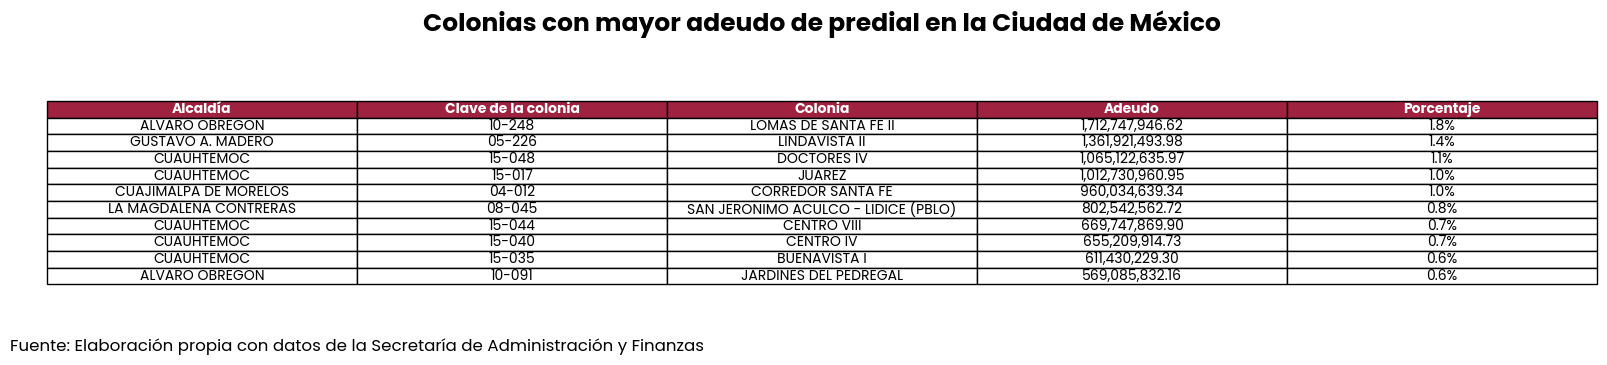

In [60]:
#Definir color de la tabla
colors = ["#9f2241","#9f2241"]
cm = LinearSegmentedColormap.from_list('custom', colors, N=10)

fig, ax = plt.subplots(figsize=(20, 4))
num_columns = len(top_colonias.columns)

# Aplicar el color a las columnas
col_colours = [cm(0.3 + i * (0.7 - 0.3) / (num_columns - 1)) for i in range(num_columns)]
#Agregar titulo
plt.title('Colonias con mayor adeudo de predial en la Ciudad de México',  fontsize=18, fontweight='bold', color='black')
#Eliminar ejes
plt.axis('off')
#Añadir fuente
plt.text(0.2, 0, "Fuente: Elaboración propia con datos de la Secretaría de Administración y Finanzas"
                , ha='center', va='center', fontsize=12, color='black')

# Crear tabla
table = ax.table(cellText=top_colonias.values, colLabels=top_colonias.columns, loc='center', colColours=col_colours)

# Ajustar tamaño de fuente
table.auto_set_font_size(False)
table.set_fontsize(10)

for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header row
        cell.set_text_props(ha='center', color='white', fontweight='bold')
    else:
        cell.set_text_props(ha='center')

#Salvar tabla
plt.savefig('tabla_colonias_adeudos.png', dpi=300, bbox_inches='tight')

In [64]:
#Alcaldías


alcadias=gpd.read_file("https://datos.cdmx.gob.mx/dataset/bae265a8-d1f6-4614-b399-4184bc93e027/resource/deb5c583-84e2-4e07-a706-1b3a0dbc99b0/download/limite-de-las-alcaldas.json")
alcadias.columns=alcadias.columns.str.lower()
alcadias

cvegeo cve_ent cve_mun                  nomgeo  \
0   09002      09     002            Azcapotzalco   
1   09003      09     003                Coyoacán   
2   09004      09     004   Cuajimalpa de Morelos   
3   09005      09     005       Gustavo A. Madero   
4   09006      09     006               Iztacalco   
5   09007      09     007              Iztapalapa   
6   09008      09     008  La Magdalena Contreras   
7   09009      09     009              Milpa Alta   
8   09010      09     010          Álvaro Obregón   
9   09011      09     011                 Tláhuac   
10  09012      09     012                 Tlalpan   
11  09013      09     013              Xochimilco   
12  09014      09     014           Benito Juárez   
13  09015      09     015              Cuauhtémoc   
14  09016      09     016          Miguel Hidalgo   
15  09017      09     017     Venustiano Carranza   

                                             geometry  
0   POLYGON ((-99.18231 19.50748, -99.18229 19.507...  
1   POLYGON ((-99.13427 19.35654, -99.13397 19.356...  
2   POLYGON ((-99.25738 19.40112, -99.25698 19.400...  
3   POLYGON ((-99.11124 19.56150, -99.11485 19.557...  
4   POLYGON ((-99.05751 19.40673, -99.05753 19.406...  
5   POLYGON ((-99.01692 19.38187, -99.01652 19.381...  
6   POLYGON ((-99.20819 19.33674, -99.20859 19.336...  
7   POLYGON ((-98.99718 19.22747, -98.99723 19.227...  
8   POLYGON ((-99.18906 19.39559, -99.18871 19.394...  
9   POLYGON ((-98.97881 19.32392, -98.97856 19.323...  
10  POLYGON ((-99.19671 19.30240, -99.19629 19.302...  
11  POLYGON ((-99.09880 19.32045, -99.09870 19.319...  
12  POLYGON ((-99.14762 19.40401, -99.14681 19.403...  
13  POLYGON ((-99.12951 19.46265, -99.12919 19.462...  
14  POLYGON ((-99.19045 19.47044, -99.19058 19.467...  
15  POLYGON ((-99.10946 19.45292, -99.10895 19.452...

In [68]:
m = folium.Map(
    location=[19.4326, -99.1332],
    zoom_start=11,
    tiles=None
)

# Google Maps layer
google_hybrid = folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
    name='Google Maps',
    attr="Fuente: Elaborado con información de INEGI. Censo de Población y Vivienda 2020 y de Inside Airbnb",
    overlay=False,
    control=True
)
google_hybrid.add_to(m)

# Colormap for the color bar
colormap = colors.LinearSegmentedColormap.from_list('YlOrRd', ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026'])

# Get min and max values
min_value = colonias_adeudos['adeudos_total'].min()
max_value = colonias_adeudos['adeudos_total'].max()

# Define color scale
color_scale = cm.LinearColormap(
    ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026'],
    vmin=min_value, vmax=max_value, caption="Monto de adeudo de predial"
)

# Preformat the adeudos_total field
colonias_adeudos['adeudos_total_formatted'] = colonias_adeudos['adeudos_total'].apply(lambda x: f"${x:,.2f}")

# Define style function
def style_function(feature):
    porcentaje = feature['properties']['adeudos_total']
    if porcentaje is None:
        color = '#ffffff'
    else:
        normalized_value = (porcentaje - min_value) / (max_value - min_value)
        color = colors.to_hex(colormap(normalized_value))
    
    return {
        'fillColor': color,
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    }


# Add GeoJson layer with formatted tooltips
tooltip = folium.GeoJsonTooltip(
    fields=['cveut', 'ut', 'adeudos_total_formatted'],  # Use the preformatted column
    aliases=['Clave de la colonia', 'Nombre de la colonia', 'Monto de adeudo'],
    style=(
        "background-color: white; color: black; font-family: 'Century Gothic'; font-size: 12px; padding: 5px;"
    )
)

folium.GeoJson(
    colonias_adeudos,
    name='Colonias',
    style_function=style_function,
    tooltip=tooltip
).add_to(m)

#Añadir capa de alcaldías
folium.GeoJson(
    alcadias,
    name='Alcaldías',
    style_function=lambda x: {
        'color': '#756bb1',
        'weight': 3,
        'fillColor': 'white',
        'fillOpacity': 0
    }
).add_to(m)



# Add color scale
color_scale.add_to(m)

# Layer control
folium.LayerControl(collapsed=False).add_to(m)

#Salvar mapa y mostrar
m.save('mapa_adeudos_colonias.html')
m
